Práctica 2 (parte 1)
# Aproximación de una función con un perceptrón multicapa

In [112]:
# Realizamos las importaciones necesarias
import numpy as np
import matplotlib.pyplot as plt


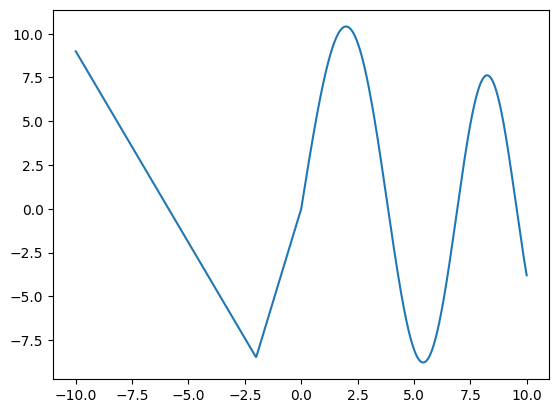

In [113]:
# Representamos la función que vamos a aproximar
def f(x):
    if x < -2:
        return -2.186 * x - 12.864
    elif x >= -2 and x < 0:
        return 4.246 * x
    else :
        return 19 * np.exp(-0.05 * x - 0.5) * np.sin(0.03 * x**2 + 0.7 * x)


# Representación de la función
x = np.linspace(-10, 10, 1000)
f_np = np.vectorize(f)  # Vectorizamos la función para poder aplicarla a un array de numpy
y = f_np(x)
plt.plot(x, y)
plt.show()

Definimos algunas funciones de transferencia:

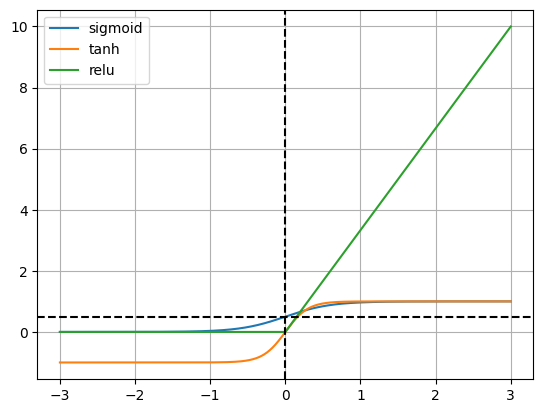

In [114]:
# Funciones de transferencia:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)

# Las representamos con un gráfico
x_fun = np.linspace(-3, 3, 1000)
y_sigmoid = sigmoid(x)
y_tanh = tanh(x)
y_relu = relu(x)
plt.plot(x_fun, y_sigmoid, label="sigmoid")
plt.plot(x_fun, y_tanh, label="tanh")
plt.plot(x_fun, y_relu, label="relu")
plt.axvline(x=0, color="black", linestyle="--")
plt.axhline(y=0.5, color="black", linestyle="--")
plt.grid()
plt.legend()
plt.show()


# Calculamos también sus derivadas
def derivada_sigmoid(x):
    return np.exp(-x) / (2 * np.exp(-x) + np.exp(-x) ** 2 + 1)

def derivada_tanh(x):
    return -(np.tanh(x) ** 2) + 1

def derivada_relu(x):
    return np.where(x == 0, 0, 1)

La arquitectura de la red neuronal que vamos a utilizar es la que se define aquí:

In [115]:
# Definición de la arquitectura de la red neuronal:
# Estos son los mejores resultados que hemos obtenido para la funcion sigmoidal
tam_salida = 1
train_percent = 0.8
cantidad_puntos = 200
neuronas_ocultas = 50
cte_aprendizaje = 0.001
iteraciones = 800000

Creamos el conjunto de datos que luego usaremos para el entrenamiento

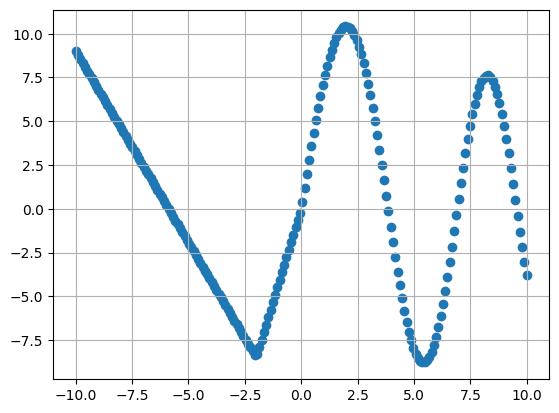

In [116]:
# Creación del dataset:

x_data = np.linspace(-10, 10, cantidad_puntos) # Para puntos equidistantes
# x_data = np.random.uniform(-10, 10, cantidad_puntos) # Para puntos aleatorios
y_data = f_np(x_data)
data = np.array([x_data, y_data]).T
np.random.shuffle(data)

# Representación del dataset
plt.scatter(data[:, 0], data[:, 1])
plt.grid()
plt.show()

Separamos los datos disponibles en entrenamiento y test

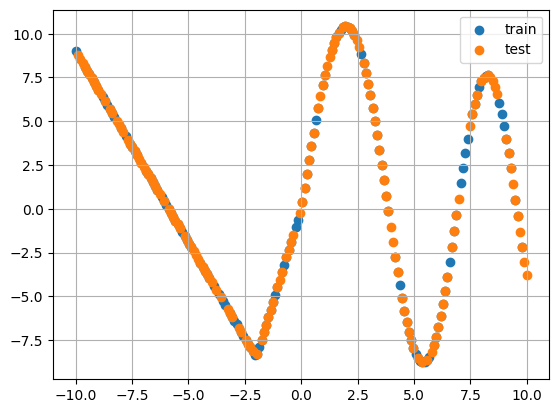

In [117]:
# Creacion de entrenamiento y test
train_data = data[: int(train_percent * cantidad_puntos)]
test_data = data[int((1 - train_percent) * cantidad_puntos) :]

# Extraer las características (x) y las etiquetas (y) para entrenamiento y test
x_train = train_data[:, 0].reshape(-1, 1)  # Cambiar la forma de x_train
y_train = train_data[:, 1].reshape(-1, 1)  # Cambiar la forma de y_train

x_test = test_data[:, 0].reshape(-1, 1)  # Cambiar la forma de x_test
y_test = test_data[:, 1].reshape(-1, 1)  # Cambiar la forma de y_test

# Representación de datos de entrenamiento y test
plt.scatter(x_train, y_train, label="train")
plt.scatter(x_test, y_test, label="test")
plt.legend()
plt.grid()
plt.show()

Entrenamos la red neuronal

In [118]:
# A diferencia de otras ocasiones, he decidido usar orientación a objetos para la implementación de la red neuronal en esta práctica.

class MLP:
    def __init__(self, neuronas_ocultas, eta, tam_salida, activation_function, activation_function_derivative):
        self.eta = eta
        self.tam_salida = tam_salida
        self.activation_function = activation_function
        self.activation_function_derivative = activation_function_derivative
        self.neuronas_ocultas = neuronas_ocultas
        
    
    def train(self, x_train, y_train, iteraciones, resultados_parciales=False):
        # Inicialización de los pesos y los umbrales
        self.weights_input_hidden = np.random.randn(x_train.shape[1], neuronas_ocultas)
        self.bias_hidden = np.random.randn(neuronas_ocultas)
        self.weights_hidden_output = np.random.randn(neuronas_ocultas, tam_salida)
        self.bias_output = np.random.randn(tam_salida)
        
        if resultados_parciales:
            ev_pesos_ocultos = []
            aprox_inicial = np.dot(sigmoid(np.dot(x_train, self.weights_input_hidden) + self.bias_hidden), self.weights_hidden_output) + self.bias_output

        # Entrenamiento
        for epoch in range(iteraciones):
            # Forward propagation
            hidden_inputs = np.dot(x_train, self.weights_input_hidden) + self.bias_hidden
            hidden_outputs = self.activation_function(hidden_inputs)
            output = np.dot(hidden_outputs, self.weights_hidden_output) + self.bias_output

            # Backpropagation
            output_error = output - y_train
            output_delta = output_error * self.activation_function_derivative(output)

            hidden_error = np.dot(output_delta, self.weights_hidden_output.T)
            hidden_delta = hidden_error * self.activation_function_derivative(hidden_inputs)

            # Update weights and biases
            self.weights_hidden_output -= self.eta * np.dot(hidden_outputs.T, output_delta)
            self.bias_output -= self.eta * np.sum(output_delta, axis=0)
            self.weights_input_hidden -= self.eta * np.dot(x_train.T, hidden_delta)
            self.bias_hidden -= self.eta * np.sum(hidden_delta, axis=0)
            
            if resultados_parciales and epoch % 10 == 0:
                ev_pesos_ocultos.append(self.weights_input_hidden.copy())
        
        if resultados_parciales:
            return ev_pesos_ocultos, aprox_inicial
            
    def predict(self, x_test):
        # Evaluate the neural network
        hidden_layer_output = sigmoid(np.dot(x_test, self.weights_input_hidden) + self.bias_hidden)
        predicted_output = np.dot(hidden_layer_output, self.weights_hidden_output) + self.bias_output
        return predicted_output

In [119]:
# Entrenamiento de la red neuronal
mlp = MLP(neuronas_ocultas, cte_aprendizaje, tam_salida, tanh, derivada_tanh)
ev_pesos, aprox_inicial = mlp.train(x_train, y_train, iteraciones, True)

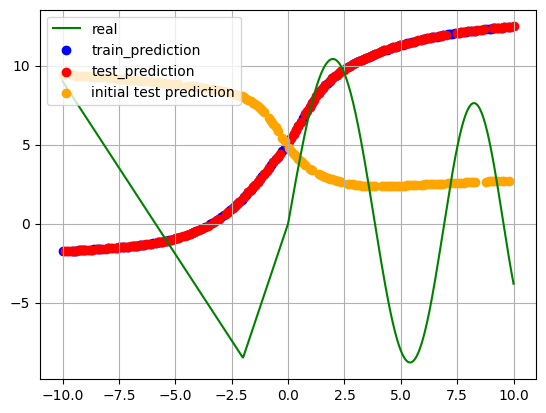

In [120]:
# Probamos la red neuronal
mlp.predict(x_test)

# Representamos todo
plt.plot(x, y, label="real", color="green")
plt.scatter(x_train, mlp.predict(x_train), label="train_prediction", color="blue")
plt.scatter(x_test, mlp.predict(x_test), label="test_prediction", color="red")
plt.scatter(x_train, aprox_inicial, label="initial test prediction", color="orange")

plt.legend()
plt.grid()
plt.show()

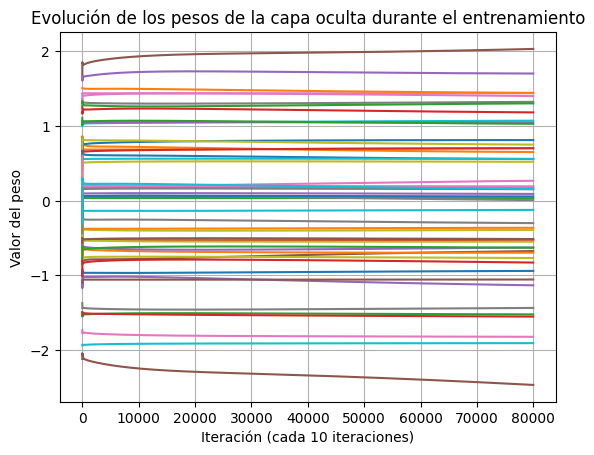

In [121]:
# Graficamos la evolución de los pesos
for i in range(neuronas_ocultas):
    pesos = [peso[0, i] for peso in ev_pesos]
    plt.plot(pesos, label=f'Peso {i+1}')

plt.title("Evolución de los pesos de la capa oculta durante el entrenamiento")
plt.xlabel("Iteración (cada 10 iteraciones)")
plt.ylabel("Valor del peso")
#plt.legend()
plt.grid()
plt.show()

C:\Users\alpri\AppData\Local\Temp\ipykernel_20600\274778673.py:26: RuntimeWarning: invalid value encountered in add
  hidden_inputs = np.dot(x_train, self.weights_input_hidden) + self.bias_hidden


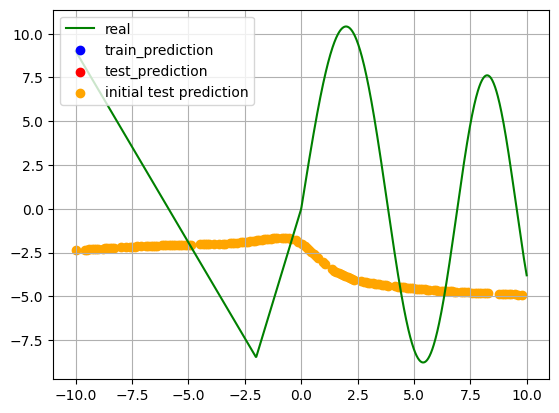

In [122]:
#Probamos con la relu

mlp = MLP(100, cte_aprendizaje, tam_salida, relu, derivada_relu)
ev_pesos, aprox_inicial = mlp.train(x_train, y_train, 8000, True)

# Probamos la red neuronal
mlp.predict(x_test)

# Representamos todo
plt.plot(x, y, label="real", color="green")
plt.scatter(x_train, mlp.predict(x_train), label="train_prediction", color="blue")
plt.scatter(x_test, mlp.predict(x_test), label="test_prediction", color="red")
plt.scatter(x_train, aprox_inicial, label="initial test prediction", color="orange")

plt.legend()
plt.grid()
plt.show()

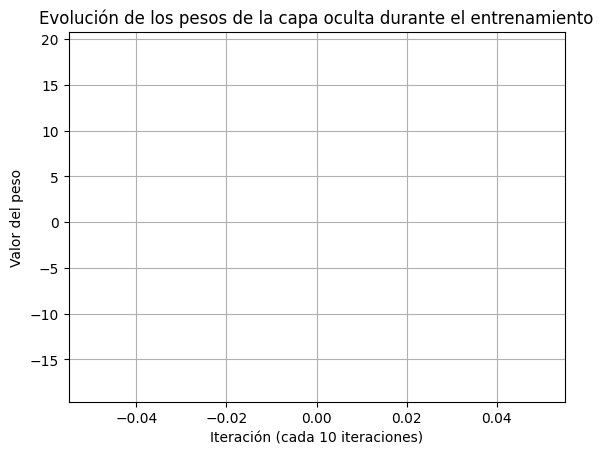

In [123]:
# Graficamos la evolución de los pesos con relu
for i in range(neuronas_ocultas):
    pesos = [peso[0, i] for peso in ev_pesos]
    plt.plot(pesos, label=f'Peso {i+1}')

plt.title("Evolución de los pesos de la capa oculta durante el entrenamiento")
plt.xlabel("Iteración (cada 10 iteraciones)")
plt.ylabel("Valor del peso")
#plt.legend()
plt.grid()
plt.gray()
plt.show()